In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import fetch_20newsgroups
from time import time

In [3]:
n_words = 2000
n_topics = 10

In [4]:
print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1, #subset='train',
                             remove=('headers', 'footers', 'quotes'))

data_samples = dataset.data[:2000]
n_docs = len(data_samples)

dataset_test = fetch_20newsgroups(shuffle=True, random_state=1, subset='test',
                             remove=('headers', 'footers', 'quotes'))

data_test = dataset_test.data
n_docs_test = len(data_test)

print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.982s.


Vectorize documents and get Count Matrix
----------------------------------------------

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_words,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf features for LDA...
done in 0.346s.


In [7]:
tf_test = tf_vectorizer.fit_transform(data_test)

In [8]:
import numpy as np
from scipy.sparse import find

In [9]:
(I, J, K) = find(tf)

docs_idxs = [[] for _ in range(n_docs)]
docs_cnts = [[] for _ in range(n_docs)]

for r, c, n in zip(I, J, K) :
    docs_idxs[r].append(c)
    docs_cnts[r].append(n)

In [10]:
# (I, J, K) = find(tf_test)

# docs_idxs_test = [[] for _ in range(n_docs_test)]
# docs_cnts_test = [[] for _ in range(n_docs_test)]

# for r, c, n in zip(I, J, K) :
#     docs_idxs_test[r].append(c)
#     docs_cnts_test[r].append(n)

Initialize Parameters
------------------------

In [10]:
alpha = 0.1
beta = 0.01
offset = 2
kappa = 0.75

In [11]:
from tqdm import tqdm_notebook
from scipy.special import psi

In [12]:
from scipy.special import gammaln, logsumexp

def perp(lambda_zt, didxs, dcnts) :
    score = 0
    n_docs = len(didxs)
    lambda_hat, gamma = update_doc(range(n_docs), lambda_zt, didxs, dcnts)
    
    lambda_psi = psi(lambda_zt) - psi(lambda_zt.sum(1))[:, None]
    gamma_psi = psi(gamma) - psi(gamma.sum(1))[:, None]

    Nd = 0
    for j, d in enumerate(range(n_docs)) :
        words = didxs[d]
        cnts = dcnts[d]
        
        Nd += sum(cnts)
        
        e_theta = gamma_psi[j]
        e_beta =  lambda_psi[:, words]

        topic_assign = e_theta[:, None] + e_beta 
        topic_assign = logsumexp(topic_assign, axis=0)
        score += np.dot(topic_assign , cnts)
       
    score += np.sum((alpha - gamma) * gamma_psi)
    score += np.sum(gammaln(gamma) - gammaln(alpha))
    score += np.sum(gammaln(alpha * n_topics) - gammaln(gamma.sum(1))[:, np.newaxis])
    
    score += np.sum((beta - lambda_zt) * lambda_psi)
    score += np.sum(gammaln(lambda_zt) - gammaln(beta))
    score += np.sum(gammaln(beta * n_topics) - gammaln(lambda_zt.sum(1))[:, np.newaxis])
    
    score /= Nd
    return np.exp(-score)

In [13]:
def update_doc(docs, lambda_zt, docs_idxs, docs_cnts) :
    lambda_psi = np.exp(psi(lambda_zt) - psi(lambda_zt.sum(1))[:, None])
    
    lambda_hat = np.zeros((n_topics, n_words))
    gamma_ret = np.zeros((len(docs), n_topics))
    for j, d in enumerate(docs) :
        words = docs_idxs[d]
        cnts = docs_cnts[d]
        
        topic_assign = np.zeros((n_topics, len(words)))
        gamma = np.random.gamma(100., 1/100., (n_topics))
        e_beta =  lambda_psi[:, words] #(K, N_d)

        for i in range(100) :  
            prev_gamma = gamma
            e_theta = np.exp(psi(gamma) - psi(gamma.sum()))

            topic_assign = e_theta[:, None] * e_beta 
            topic_assign = topic_assign / topic_assign.sum(0)

            gamma = alpha + np.dot(topic_assign , cnts)
            if np.mean(np.abs(prev_gamma - gamma)) < 0.001 :
                break
                
        gamma_ret[j, :] = gamma

        lambda_hat[:, words] += (topic_assign * cnts)

    return lambda_hat, gamma_ret

In [14]:
def update_lambda_zt(docs, t, lambda_zt) :
    lr_t = (t + offset) ** (-kappa)
    lambda_hat, gamma_ret = update_doc(docs, lambda_zt, docs_idxs, docs_cnts) 
    lambda_hat = lambda_hat * n_docs/len(docs) + beta
    lambda_zt = (1 - lr_t) * (lambda_zt) + lr_t * (lambda_hat)
    
    return lambda_zt

def run_SVI(n_iters, bsize) :    
    t = 0
    lambda_zt = np.random.gamma(100., 1/100., (n_topics, n_words))
    
    perps = np.zeros(n_iters)
    
    for i in tqdm_notebook(range(n_iters)) :
        for d in range(0, n_docs, bsize) :
            batch = range(d, min(d+bsize, n_docs))
            lambda_zt = update_lambda_zt(batch, t, lambda_zt)
            t += 1
        #perps[i] = perp(lambda_zt, docs_idxs_test, docs_cnts_test)
            
    return lambda_zt, perps

In [15]:
lambda_zt, perps = run_SVI(100, 32)

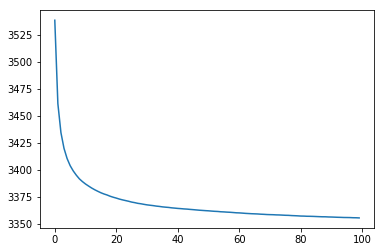

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(perps)
plt.show()

In [16]:
def get_top_words(word_list, phi) :
    max_args = np.argsort(phi, axis=1)[:, -10:] 
    for t in range(n_topics) :
        print([word_list[i] for i in max_args[t]])

In [17]:
word_list = tf_vectorizer.get_feature_names()
get_top_words(word_list, lambda_zt)

['kuwait', 'wondering', 'washington', 'likely', 'version', 'having', 'cause', 'press', 'thousand', 'products']
['launch', 'director', 'gov', 'peter', 'noticed', 'weapons', 'directory', 'tom', 'says', 'years']
['correctly', 'natural', 'year', 'selling', 'carry', 'earth', 'gas', 'caused', 'document', 'drug']
['xfree86', 'includes', 'automatic', 'followed', 'sounds', '06', 'noticed', '00', 'controller', '56']
['tom', 'likely', 'se', 'doing', 'doubt', 'thy', 'kuwait', 'keyboard', 'gopher', 'peter']
['video', 'personally', 'functions', 'sexual', 'final', 'comp', 'greek', 'widgets', 'majority', 'electronics']
['oh', 'claim', 'applied', 'gun', 'cc', 'joseph', 'peter', 'hole', 'position', 'james']
['written', 'hold', 'story', 'anti', 'happens', 'store', 'll', 'ed', 'father', 'criminal']
['domain', 'thy', 'killing', 'lcs', 'greece', 'likely', 'keyboard', 'using', 'rom', 'doubt']
['1000', 'policy', '14', '12', '10', '1990', 'terminal', '09', 'st', '06']
